In [6]:
using Revise

In [7]:
using PyPlot, Statistics
using ClimateMARGO

In [8]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Utils
include("ebm.jl");

### Stylized Extended RCP8.5 (ECP8.5) scenario

In [9]:
Δt = 5.
initial_year = 0
final_year = 1000.
t_arr = collect(initial_year:Δt:final_year)



# CO2 increasing compount 1%/year
c0 = 280.
CO2e = c0*(1.01).^t_arr;
CO2e[ CO2e .> 2*c0] .= 2*c0

# Take derivative of CO2 concentrations to estimate r*q
rq = zeros(size(t_arr));
rq[2:end] = diff(CO2e)/Δt

params = ClimateMARGO.IO.included_configurations["default"]
params.domain = Domain(Δt, initial_year, initial_year, final_year)
params.economics.baseline_emissions = rq/params.physics.r;
params.physics.T0 = 0.;
params.physics.c0 = c0;
model = ClimateModel(params);

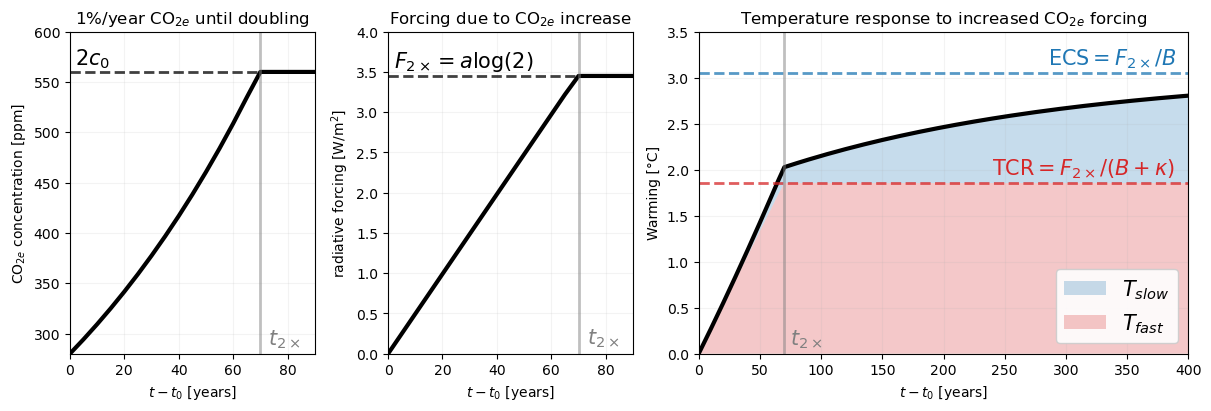

In [10]:
using PyCall
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

fig = figure(constrained_layout=true, figsize=(12,4))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(get(gs, (slice(0, 1), slice(0, 1))))
ax2 = fig.add_subplot(get(gs, (slice(0, 1), slice(1, 2))))
ax3 = fig.add_subplot(get(gs, (slice(0, 1), slice(2, 4))))

ax1.axhline(2*c0, color="k", alpha=0.75, ls="--", lw=2.)
ax1.plot(t(model), c(model), "k-", lw=3.)
ax1.set_xlim(0, 90)
ax1.set_ylim(280, 600)
ax1.grid(true, alpha=0.15)
ax1.set_xlabel(L"$t-t_{0}$ [years]")
ax1.set_ylabel(L"CO$_{2e}$ concentration [ppm]")
ax1.axvline(t(model)[argmin(CO2e .< 2*c0)], color="grey", alpha=0.5, lw=2.)
ax1.annotate(L"$t_{2\times}$", (73, 289), color="grey", size=15, alpha=1.)
ax1.annotate(L"$2c_{0}$", (2, 567.5), color="k", size=15, alpha=1.)
ax1.set_title(L"1%/year CO$_{2e}$ until doubling")

ax2.axhline(F2x(model), color="k", alpha=0.75, ls="--", lw=2.)
ax2.plot(t(model), F(model), "k-", lw=3.)
ax2.set_xlim(0, 90)
ax2.grid(true, alpha=0.15)
ax2.set_xlabel(L"$t-t_{0}$ [years]")
ax2.set_ylabel(L"radiative forcing [W/m$^{2}$]")
ax2.axvline(t(model)[argmin(CO2e .< 2*c0)], color="grey", alpha=0.5, lw=2.)
ax2.annotate(L"$t_{2\times}$", (73, 0.12), color="grey", size=15, alpha=1.)
ax2.annotate(L"$F_{2\times} = a \log(2)$", (2, F2x(model)+0.105), color="k", size=15, alpha=1.)
ax2.set_ylim(0, 4)
ax2.set_title(L"Forcing due to CO$_{2e}$ increase")

ax3.fill_between(t(model), ClimateMARGO.Diagnostics.T_fast(model), T(model), alpha=0.25, label=L"$T_{slow}$")
ax3.fill_between(t(model), 0. * ClimateMARGO.Diagnostics.T_fast(model), ClimateMARGO.Diagnostics.T_fast(model),
    facecolor="C3", alpha=0.25, label=L"$T_{fast}$")
ax3.plot(t(model), T(model), "k-", lw=3.)

ECS = F2x(model)/model.physics.B
ax3.axhline(ECS, color="C0", alpha=0.75, ls="--", lw=2.)
ax3.annotate(L"ECS$ = F_{2\times}/B$", (285, ECS+0.085), color="C0", size=15, alpha=1.)

TCR = F2x(model)/(model.physics.B + model.physics.κ)
ax3.axhline(TCR, color="C3", alpha=0.75, ls="--", lw=2.)
ax3.annotate(L"TCR$ = F_{2\times}/(B+\kappa)$", (240, TCR+0.085), color="C3", size=15, alpha=1.)

ax3.axvline(t(model)[argmin(CO2e .< 2*c0)], color="grey", alpha=0.5, lw=2.)
ax3.annotate(L"$t_{2\times}$", (75, 0.1), color="grey", size=15, alpha=1.)

ax3.set_xlim(0., 400)
ax3.set_ylim(0, 3.5)
ax3.grid(true, alpha=0.15)
ax3.set_xlabel(L"$t-t_{0}$ [years]")
ax3.set_ylabel("Warming [°C]")
ax3.set_title(L"Temperature response to increased CO$_{2e}$ forcing")
ax3.legend(loc="lower right", fontsize=15, framealpha=0.9)

fig.savefig("figures/1pctCO2_example.png", bbox_inches="tight", dpi=150)